# Quantum Optimization with Monte Carlo methods

In [1]:
# Imports
%matplotlib inline
import numpy as np
import math
from random import randint
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['interactive'] == True
import time
from scipy.optimize import minimize
from qiskit_aer.aerprovider import AerSimulator
from qiskit_aer import Aer, aerprovider
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit.library import HGate, ZGate
from qiskit.circuit import ClassicalRegister, QuantumRegister
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import *

## Helper functions

In [2]:
'''
Reversely find a parameter.

Input y is desired prepared quantum state. (L2 Normalized |y|^2 = 1)
Input optimization_method is function used to optimize the parameters.
Find parameters of variational quantum circuit "RealAmplitude" that can prepare y.
'''
def find_parameter(y, optimization_method: callable):
    n = int(math.log2(len(y))) 
    ansatz = RealAmplitudes(n, reps=1) 
    parameters = np.ones(ansatz.num_parameters)  
    simulator = AerSimulator(method='statevector') 
    meas = ClassicalRegister(1, "meas") 
    qreg = QuantumRegister(2 * n + 1) 
    c = QuantumCircuit(qreg, meas) 

    # Prepare the circuit for the swap test
    a = [1]
    b = [n + 1]
    for i in range(2, n + 1):
        a.append(i)
        b.append(n + i)

    final = c.compose(ansatz, a) 
    final.initialize(y, b) 
    final.save_statevector(label="ans") 
    final.h(0) 

    # Perform the swap test
    for i in range(1, n + 1):
        final.cswap(0, i, n + i) 
    final.h(0) 
    final.measure([0], meas) 

    # Transpile and run the circuit
    circ = transpile(final, simulator) 
    circfinal = circ.assign_parameters(parameters) 
    results = simulator.run(circfinal).result() 
    init_counts = results.get_counts()
    # print(f"Counts before optimization: {init_counts}") 
    
    # Visualize results of the original implementation
    # visualize_results(init_counts, "Before Optimization")

    # Optimization
    Energy = E(parameters, circ, simulator) 
    anneal = optimization_method(100, parameters, circ, simulator) 
    # print(f"Energy: {Energy}") 

    # Update circuit with optimized parameters and run again
    circfinal = circ.assign_parameters(anneal)
    results = simulator.run(circfinal).result()
    optimized_counts = results.get_counts() 
    

    # Calculate and print results
    b = optimized_counts.get('1', 0) # Number of times qc measured '1'
    s = (1 - (2 / 1024) * b) # Fidelity
    # circfinal.draw(output="mpl")
    # matplotlib.pyplot.show() 
    # print(f"After optimization: {str(results.get_counts())}") 
    # print(f"Fidelity: {s}")

    # Visualize results of the Monte Carlo optimization
    # visualize_results(optimized_counts, "After Optimization")

    # Calculate and print partial traces
    temp = partial_trace(results.data(0)['ans'], [0, 3, 4])
    partial = np.diagonal(temp)
    temp = partial_trace(results.data(0)['ans'], [0, 1, 2])
    partial2 = np.diagonal(temp)
    norm = np.linalg.norm(partial - partial2) 
    # print("Norm of the difference between partial traces:", norm)

    return parameters, s

# Function to calculate cost based on parameters
def cost_func(params, ansatz, simulator):
    circfinal = ansatz.assign_parameters(params) 
    results = simulator.run(circfinal, shots=1024).result() 
    counts = results.get_counts() 
    b = counts.get('1', 0) 
    s = -1 * (1 - ((2 / 1024) * b)) 
    return s 

# Function to calculate energy based on parameters
def E(params, ansatz, simulator):
    circfinal = ansatz.assign_parameters(params) 
    results = simulator.run(circfinal, shots=20).result() 
    temp = partial_trace(results.data(0)['ans'], [0, 3, 4])
    partial = np.diagonal(temp) 
    temp = partial_trace(results.data(0)['ans'], [0, 1, 2])
    partial2 = np.diagonal(temp) 
    norm = np.linalg.norm(partial - partial2) 
    return norm 

# Function to visualize the results of the quantum circuit
def visualize_results(counts, title):
    plt.bar(counts.keys(), counts.values())
    plt.title(title)
    plt.xlabel('Measurement Outcome')
    plt.ylabel('Counts')
    plt.show()


## Monte Carlo Optimization Functions

In [3]:
# Simulated Annealing optimization
def simulated_annealing(runs, params, ansatz, simulator):
    B = E(params, ansatz, simulator) 
    prev_E = B

    # Temperature function for simulated annealing
    def T(t):
        c = 0.02
        a = 0.01
        temperature = c / (a + math.log(t)) 
        return temperature

    # Main loop for simulated annealing
    for t in range(1, runs):
        delta = np.random.normal(0, .1, 4) 
        params_new = params + delta 
        E_new = E(params_new, ansatz, simulator) 
        delta_E = E_new - prev_E 

        if delta_E <= 0:
            params = params_new
            prev_E = E_new
        else:
            h = math.pow(math.e, -1 * delta_E / T(t)) 
            U = np.random.normal(.5, .5, 1) 
            if U < h:
                params = params_new
                prev_E = E_new

    return params 

# Global Best Particle Swarm optimization
def gbest_pso(runs, params, ansatz, simulator):
    num_particles = 20  # Number of particles in the swarm
    dimensions = len(params)  # Number of parameters to optimize

    particles = np.random.rand(num_particles, dimensions) * 2 - 1  # Random positions in range [-1, 1]
    velocities = np.zeros((num_particles, dimensions))  # Initial velocities
    personal_best_positions = np.copy(particles)  # Initial best positions for each particle
    personal_best_scores = [cost_func(p, ansatz, simulator) for p in particles]  # Initial best scores for each particle

    global_best_position = personal_best_positions[np.argmin(personal_best_scores)]  # Best position from all particles

    for j in range(runs):
        # Update personal best and global best
        for i in range(num_particles):
            score = cost_func(particles[i], ansatz, simulator)  # New score

            # Update personal best
            if score < personal_best_scores[i]:
                personal_best_scores[i] = score
                personal_best_positions[i] = particles[i]

            # Update global best
            if score < cost_func(global_best_position, ansatz, simulator):
                global_best_position = particles[i]

        # Update velocities and positions
        for i in range(num_particles):
            c1 = 2.0  # Personal best weight
            c2 = 2.0  # Global best weight
            r1 = np.random.rand(dimensions)
            r2 = np.random.rand(dimensions)

            # Update velocity
            velocities[i] = (0.5 * velocities[i] + 
                            c1 * r1 * (personal_best_positions[i] - particles[i]) + 
                            c2 * r2 * (global_best_position - particles[i]))
            
            # Limit the maximum velocity
            max_velocity = 0.1
            velocities[i] = np.clip(velocities[i], -max_velocity, max_velocity)

            # Update position
            particles[i] = particles[i] + velocities[i]

    return global_best_position

# Differential Evolution optimization
def diff_evolution(runs, params, ansatz, simulator):
    bounds = [(-1, 1)] * len(params)
    dimensions = len(bounds)
    popsize = 20
    mut = 0.8  # Mutation factor, usually chosen from the interval [0.5, 2.0]
    crossp = 0.7  # Crossover probability, between [0, 1]

    # Initialization
    pop = np.random.rand(popsize, dimensions)
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b)
    pop_denorm = min_b + pop * diff
    fitness = np.asarray([cost_func(ind, ansatz, simulator) for ind in pop_denorm])
    best_idx = np.argmin(fitness)
    best = pop_denorm[best_idx]

    for i in range(runs):
        for j in range(popsize):
            # Mutation
            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c = pop[np.random.choice(idxs, 3, replace=False)]
            mutant = np.clip(a + mut * (b - c), 0, 1)

            # Recombination
            cross_points = np.random.rand(dimensions) < crossp
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, pop[j])

            # Replacement
            trial_denorm = min_b + trial * diff
            f = cost_func(trial_denorm, ansatz, simulator)
            if f < fitness[j]:
                fitness[j] = f
                pop[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial_denorm

    return best

# Stochastic Hill Climbing optimization
def stochastic_hill_climbing(runs, params, ansatz, simulator):
    max_iterations = 20
    step_size = 0.1 # Step size for perturbation
    threshold = 0.9
    best_state = None
    best_score = float('inf')

    for restart in range(1, runs + 1):
        current_state = params.copy()
        current_score = cost_func(current_state, ansatz, simulator)

        for iteration in range(1, max_iterations + 1):
            # Apply a random perturbation to generate a neighboring state
            neighbor = current_state + np.random.normal(0, step_size, size=current_state.shape)
            neighbor_score = cost_func(neighbor, ansatz, simulator)

            if neighbor_score < current_score:
                current_state = neighbor
                current_score = neighbor_score

            # Update the best state and score if current is better
            if current_score < best_score:
                best_state = current_state
                best_score = current_score

            if current_score >= threshold:
                break
    return best_state

# Compare the results


Random vector 1: [0.04466278 0.43546209 0.87092417 0.22331389]
Simulated Annealing: fidelity = 0.91, runtime = 0.17 sec
Particle Swarm: fidelity = 1.0, runtime = 10.02 sec
Differential Evolution: fidelity = 0.81, runtime = 4.88 sec
Stochastic Hill Climbing: fidelity = 0.95, runtime = 4.97 sec

Random vector 2: [0.59778587 0.59778587 0.03231275 0.53316037]
Simulated Annealing: fidelity = 1.0, runtime = 0.08 sec
Particle Swarm: fidelity = 1.0, runtime = 9.64 sec
Differential Evolution: fidelity = 1.0, runtime = 5.22 sec
Stochastic Hill Climbing: fidelity = 1.0, runtime = 5.1 sec

Random vector 3: [0.63049375 0.40650255 0.60560584 0.26547105]
Simulated Annealing: fidelity = 0.95, runtime = 0.08 sec
Particle Swarm: fidelity = 0.99, runtime = 9.48 sec
Differential Evolution: fidelity = 1.0, runtime = 4.83 sec
Stochastic Hill Climbing: fidelity = 1.0, runtime = 5.0 sec

Random vector 4: [0.16753568 0.7455338  0.00837678 0.64501239]
Simulated Annealing: fidelity = 0.92, runtime = 0.09 sec
Pa

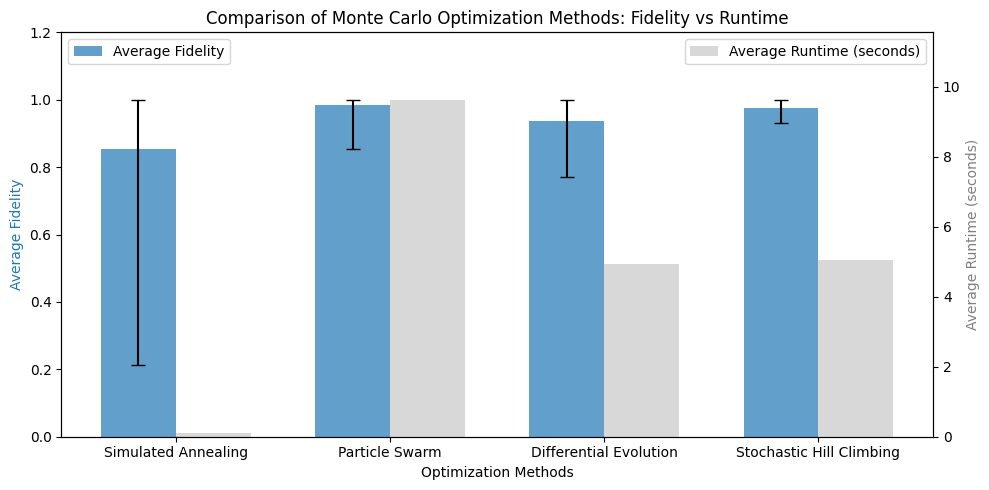

In [4]:
num_runs = 10
sa_fidelity_values = []
pso_fidelity_values = []
de_fidelity_values = []
shc_fidelity_values = []
sa_runtimes = []
pso_runtimes = []
de_runtimes = []
shc_runtimes = []

for i in range(num_runs):
    randvect = [randint(0, 100) for _ in range(4)] 
    norm = np.linalg.norm(randvect) 
    randvect = randvect / norm 
    print(f"\nRandom vector {i+1}: {randvect}")

    # Timing for Simulated Annealing
    start_time = time.time()
    original_parameters_sa, sa_fidelity = find_parameter(randvect, simulated_annealing)
    sa_time = time.time() - start_time
    sa_fidelity_values.append(sa_fidelity)
    sa_runtimes.append(sa_time)
    print(f"Simulated Annealing: fidelity = {round(sa_fidelity, 2)}, runtime = {round(sa_time,2)} sec")

    # Timing for Particle Swarm Optimization
    start_time = time.time()
    original_parameters_pso, pso_fidelity = find_parameter(randvect, gbest_pso)
    pso_time = time.time() - start_time
    pso_fidelity_values.append(pso_fidelity)
    pso_runtimes.append(pso_time)
    print(f"Particle Swarm: fidelity = {round(pso_fidelity, 2)}, runtime = {round(pso_time, 2)} sec")

    # Timing for Differential Evolution
    start_time = time.time()
    original_parameters_de, de_fidelity = find_parameter(randvect, diff_evolution)
    de_time = time.time() - start_time
    de_fidelity_values.append(de_fidelity)
    de_runtimes.append(de_time)
    print(f"Differential Evolution: fidelity = {round(de_fidelity, 2)}, runtime = {round(de_time, 2)} sec")

    # Timing for Stochastic Hill Climbing
    start_time = time.time()
    original_parameters_shc, shc_fidelity = find_parameter(randvect, stochastic_hill_climbing)
    shc_time = time.time() - start_time
    shc_fidelity_values.append(shc_fidelity)
    shc_runtimes.append(shc_time)
    print(f"Stochastic Hill Climbing: fidelity = {round(shc_fidelity, 2)}, runtime = {round(shc_time, 2)} sec")

# Calculate average fidelity
sa_avg_fidelity = np.mean(sa_fidelity_values)
pso_avg_fidelity = np.mean(pso_fidelity_values)
de_avg_fidelity = np.mean(de_fidelity_values)
shc_avg_fidelity = np.mean(shc_fidelity_values)

# Calculate error bars for fidelity
error_bars = [
    [sa_avg_fidelity - np.min(sa_fidelity_values), np.max(sa_fidelity_values) - sa_avg_fidelity],
    [pso_avg_fidelity - np.min(pso_fidelity_values), np.max(pso_fidelity_values) - pso_avg_fidelity],
    [de_avg_fidelity - np.min(de_fidelity_values), np.max(de_fidelity_values) - de_avg_fidelity],
    [shc_avg_fidelity - np.min(shc_fidelity_values), np.max(shc_fidelity_values) - shc_avg_fidelity]
]

# Calculate average runtimes
sa_avg_runtime = np.mean(sa_runtimes)
pso_avg_runtime = np.mean(pso_runtimes)
de_avg_runtime = np.mean(de_runtimes)
shc_avg_runtime = np.mean(shc_runtimes)

# Plotting
methods = ['Simulated Annealing', 'Particle Swarm', 'Differential Evolution', 'Stochastic Hill Climbing']
avg_fidelity = [sa_avg_fidelity, pso_avg_fidelity, de_avg_fidelity, shc_avg_fidelity]
avg_runtime = [sa_avg_runtime, pso_avg_runtime, de_avg_runtime, shc_avg_runtime]

bar_width = 0.35
x = np.arange(len(methods))
fig, ax1 = plt.subplots(figsize=(10, 5))
bars1 = ax1.bar(x - bar_width/2, avg_fidelity, bar_width, label='Average Fidelity', color='tab:blue', alpha=0.7, 
                yerr=np.array(error_bars).T, capsize = 5) # Fidelity bars
ax2 = ax1.twinx()
bars2 = ax2.bar(x + bar_width/2, avg_runtime, bar_width, label='Average Runtime (seconds)', color='grey', alpha=0.3) # Runtime bars

ax1.set_xlabel('Optimization Methods')
ax1.set_ylabel('Average Fidelity', color='tab:blue')
ax2.set_ylabel('Average Runtime (seconds)', color='grey')  
ax1.set_title('Comparison of Monte Carlo Optimization Methods: Fidelity vs Runtime')
ax1.set_xticks(x)
ax1.set_xticklabels(methods)
ax1.set_ylim(0, 1.2)  # Y-axis for fidelity
ax2.set_ylim(0, max(avg_runtime) * 1.2)  # Y-axis for runtime
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()